#Locally adaptive Bayesian covariance regression:
## Algorithm test

Here, we follow the algorithm given in [Durante, Scarpa, and Dunson (2014)](https://www.researchgate.net/profile/David_Dunson/publication/232063211_Locally_adaptive_factor_processes_for_multivariate_time_series/links/09e4150df41e8d582a000000.pdf). In particular, we are following Appendix A.2.

In [1]:
using NGPtools
using Distributions
# set random seed
srand(12345);

# Load data

In [2]:
using HDF5

fid = h5open("data/labcr_test_data.jld", "r")

vars_to_read = [:y, :tobs]  # :theta, :xi, :psi, :Σ0

for v in vars_to_read
    expr = :($v = read(fid[$("/$v")]))
    eval(expr)
end
close(fid)

In [3]:
using PyPlot
plt.style[:use]("ggplot")

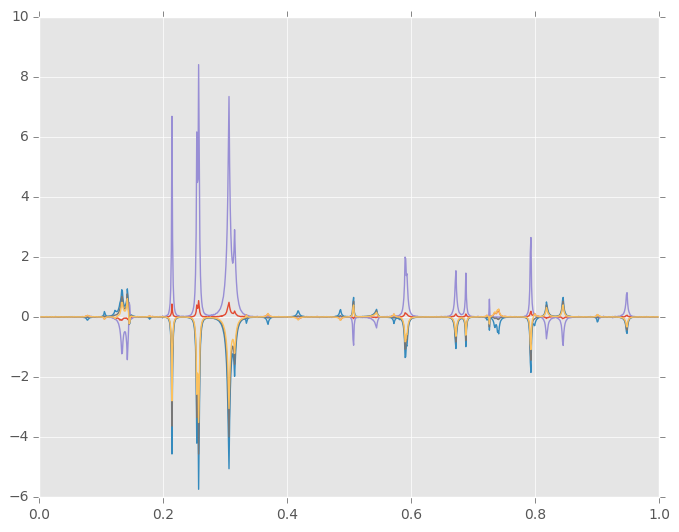

In [4]:
plot(tobs, y');

In [5]:
Np, Nt = size(y)
δ = diff(tobs)[1]

0.001

# Set up some parameters

In [6]:
NK = 2
NL = 2
Nst = NK * NL
Nm = 3 * Nst

12

In [7]:
# sampling will assume we have some variables, so let's make them

## variables to be updated
η = 0.1 * randn(NK, 1, Nt)
Θ = 0.1 * randn(Np, NL)
ϕ = rand(Gamma(3/2, 2/3), Np, NL)
ϑ = rand(Gamma(10, 1), NL)
τ = cumprod(ϑ)
Σ0 = diagm(rand(InverseGamma(1, 0.1), Np))  # 1, 0.1
σξ = 10. * ones(NL * NK)
σA = 0.5 * ones(NL * NK)
σψ = 1. * ones(NK)
σB = 1. * ones(NK)

## prior parameters
σμ = 1.
σα = 1.
aϵ, bϵ = 1., 0.1
aξ, bξ = 2., 500
aA, bA = 2., 500
aψ, bψ = 0.005, 0.005
aB, bB = 0.005, 0.005
a1, a2 = 2, 2

(2,2)

# Define sampling functions

## Sample multivariable nGP: $\Xi$

Here, the state space model is given by 

$$\begin{align}
    y_t &= Z_t \Xi + \epsilon_t \\
    \Xi &= \mathrm{vec}[(\xi_{lk})] \\
    Z_t &= [\Psi(t)^\top \otimes \Theta, 0_{p \times 2KL}] \\ 
    \epsilon_t &\sim \mathcal{N}(0, \Sigma_0) \\
    \Xi_{t + 1} &= T_t \Xi_t + R_t \Omega_t
\end{align}$$

With $\Psi$ a column vector $(K, 1)$ of means for the process, the sequences of state dynamics matrices $T_t$ and $R_t$ given by the Zhu and Dunson approximate formulae, and $\mathrm{vec}$ the concatenation by columns operator.

In [8]:
function sample_Ξ(Σ0, Θ, η, σξ, σA)
    # now these are needed for the state space model
    H = Σ0
    Z = zeros(Float64, Np, Nm, Nt)

    for t in 1:Nt
        Z[:, 1:Nst, t] = kron(η[:, :, t]', Θ)
    end
    
    samp = NGPtools.sample(y, 1, Z, H, δ, σξ, σA, σμ, σα; approx=true)[:, :, 1]
    
    ξ = samp[1:3:end, :]
    Dξ = samp[2:3:end, :]
    A = samp[3:3:end, :]
    
    return ξ, Dξ, A
end

sample_Ξ (generic function with 1 method)

## Sample $\sigma^2_\xi$ and $\sigma^2_A$

Just as in a previous notebook, we calculate these by conjugate updates:

$$\begin{align}
\sigma^2_\xi &\sim \mathrm{InvGa}\left(a_\xi + \frac{N_t}{2}, b_\xi + \frac{1}{2}R^2_\xi \right) \\
\sigma^2_A &\sim \mathrm{InvGa}\left(a_A + \frac{N_t}{2}, b_A + \frac{1}{2}R^2_A \right) \\
R^2_\xi &\equiv \sum_{i = 1}^{N_t - 1} \frac{\left(\xi'(t_{i + 1}) - \xi'(t_i) - A(t_i)\delta_i \right)^2}{\delta_i} \\
R^2_A &\equiv \sum_{i = 1}^{N_t - 1} \frac{\left(A(t_{i + 1}) - A(t_i) \right)^2}{\delta_i}
\end{align}$$

(Note that because we have assumed the approximate model (i.e., $\delta \ll 1$), the posterior is available in closed form as above. Zhu and Dunson, by contrast, used independence chain proposals for the two variances above.)

In [9]:
function sample_σξ(Dξ, A)
    R2ξ = sum((diff(Dξ, 2) - A[:, 1:end-1] * δ).^2, 2) / δ
    
    Nξ = size(A, 1)
    σξ = Array(Float64, Nξ)
    for idx in 1:Nξ
        σξ[idx] = sqrt(rand(InverseGamma(aξ + 0.5 * Nt, bξ + 0.5 * R2ξ[idx])))
    end
    return σξ
end

sample_σξ (generic function with 1 method)

In [10]:
function sample_σA(A)
    R2A = sum(diff(A, 2).^2, 2) / δ
    
    NA = size(A, 1)
    σA = Array(Float64, NA)
    for idx in 1:NA
        σA[idx] = sqrt(rand(InverseGamma(aA + 0.5 * Nt, bA + 0.5 * R2A[idx])))
    end
    return σA
end

sample_σA (generic function with 1 method)

## Update $\Sigma_0$

We have $\Sigma_0 = \mathrm{diag}(\sigma_1^2, \sigma_2^2, \ldots, \sigma_p^2)$ and
$$
\sigma_j^2 \sim \mathrm{InvGa}\left(a_\epsilon +\frac{N_t}{2}, b_\epsilon + 
\frac{1}{2}\sum_{i = 1}^{N_t} (y_j(t_i) - \hat{y}_j(t_i))^2  \right) \\
\hat{y}_j(t_i) = \sum_{lk} \theta_{jl}\xi_{lk}(t_i) \eta_k(t_i)
$$

In [11]:
function sample_Σ0(η, Θ, ξ)
    yhat = similar(y)

    for t in 1:Nt
        yhat[:, t] = kron(η[:, :, t]', Θ) * ξ[:, t]
    end
    
    SS = sum((y - yhat).^2, 2)
    
    σ2 = Array(Float64, Np)
    
    for j in 1:Np
        σ2[j] = rand(InverseGamma(aϵ + 0.5 * Nt, bϵ + 0.5 * SS[j]))
    end
    
    return diagm(σ2)
end

sample_Σ0 (generic function with 1 method)

## Update $\Psi$

Here we again approximate $\Psi$ as a nested Gaussian process with similar updates to those for $\Xi$.

In [12]:
function sample_Ψ(Σ0, Θ, ξ, σψ, σB)
    Z = zeros(Float64, Np, 3 * NK, Nt)
    H = Array(Float64, Np, Np, Nt)
    
    for t in 1:Nt
        Z_t = Θ * reshape(slice(ξ, :, t), NL, NK)
        Z[:, 1:NK, t] = Z_t
        H[:, :, t] = Z_t * Z_t' + Σ0
    end
    
    samp = NGPtools.sample(y, 1, Z, H, δ, σψ, σB, σμ, σα; approx=true, interleaved=false)[:, :, 1]
    
    Ψ = samp[1:3:end, :]
    DΨ = samp[2:3:end, :]
    B = samp[3:3:end, :]
    
    return Ψ, DΨ, B
end

sample_Ψ (generic function with 1 method)

In [13]:
function sample_σψ(DΨ, B)
    R2ψ = sum((diff(DΨ, 2) - B[:, 1:end-1] * δ).^2, 2) / δ
    
    Nψ = size(B, 1)
    σψ = Array(Float64, Nψ)
    for idx in 1:Nψ
        σψ[idx] = sqrt(rand(InverseGamma(aψ + 0.5 * Nt, bψ + 0.5 * R2ψ[idx])))
    end
    
    return σψ
end

sample_σψ (generic function with 1 method)

In [14]:
function sample_σB(B)
    R2B = sum(diff(B, 2).^2, 2) / δ
    
    NB = size(B, 1)
    σB = Array(Float64, NB)
    for idx in 1:NB
        σB[idx] = sqrt(rand(InverseGamma(aB + 0.5 * Nt, bB + 0.5 * R2B[idx])))
    end
    
    return σB
end

sample_σB (generic function with 1 method)

# Update mean residuals ($\eta$)

We have $\eta(t) = \psi(t) + \nu_t$ with $\nu \sim \mathcal{N}(0, \mathbb{1}_K)$

In [15]:
function sample_η(Ψ, Θ, ξ, Σ0)
    # calculate residuals
    yhat = similar(y)
    ν = similar(Ψ)
    
    for t in 1:Nt
        yhat[:, t] = kron(Ψ[:, t]', Θ) * ξ[:, t]
        Z_t = Θ * reshape(slice(ξ, :, t), NL, NK)
        Λ = eye(size(Z_t, 2)) + Z_t' * scale(1./diag(Σ0), Z_t)
        Σ = inv(Λ)
        ν[:, t] = rand(MvNormal(Σ * scale(Z_t', 1./diag(Σ0)) * (y[:, t] - yhat[:, t]), Σ))
        η[:, t] = Ψ[:, t] + ν[:, t]
    end
    
    return η
end

sample_η (generic function with 1 method)

# Update $\Theta$

For each row of the matrix $\Theta$, we have 

$$\begin{align}
\Theta_{j\cdot} &\sim \mathcal{N}\left({\Sigma}_\theta \sum_t \tilde{\eta}(t) \sigma^{-2}_j y_j(t), 
{\Sigma}_\theta \right) \\
{\Sigma}_\theta^{-1} &= \frac{\sum_t \tilde{\eta}(t) \tilde{\eta}(t)^\top}{\sigma^2_j} +
\mathrm{diag}(\phi_{j1}\tau_1, \ldots, \phi_{jL}\tau_L) \\
\tilde{\eta}(t) &= \xi(t)\eta(t)
\end{align}$$ 

In [16]:
function sample_Θ(ξ, Σ0, ϕ, τ)

    η_tilde = Array(Float64, NL, Nt)
    for t in 1:Nt
        η_tilde[:, t] = reshape(ξ[:, t], NL, NK) * η[:, t]
    end

    ηη = η_tilde * η_tilde'

    for j in 1:Np
        sig2j = Σ0[j, j]
        Σinv = (ηη / sig2j) + diagm(squeeze(ϕ[j, :], 1) .* τ)
        
        tol = 1e-9
        try
            Σθ = inv(Σinv + scale(tol, eye(NL)))
            μ = squeeze(Σθ * (η_tilde * y[j, :]') / sig2j, 2)
            Θ[j, :] = rand(MvNormal(μ, Σθ))
        catch
            println("Σinv = ", Σinv)
            println("Θ = ", Θ)
        end
    end
    
    return Θ
end

sample_Θ (generic function with 1 method)

# Update $\phi$

Here, 

$$
\phi_{jl} \sim \mathrm{Ga}\left(2, \frac{3 + \tau_l \theta^2_{jl}}{2} \right)
$$

In [17]:
function sample_ϕ(τ, Θ)
    for j in 1:Np, l in 1:NL
        ϕ[j, l] = rand(Gamma(2, 2 / (3 + τ[l] * Θ[j, l]^2) ))
    end
    return ϕ
end

sample_ϕ (generic function with 1 method)

# Update $\vartheta$ / $\tau$

Let 
$$\tau_l^{(-h)} = \prod_{\ell \neq h}^l \vartheta_\ell$$

Then

$$\begin{align}
\vartheta_1 &\sim \mathrm{Ga}\left(a_1 + \frac{Np \cdot NL}{2}, 
1 + \frac{1}{2} \sum_l \tau_l^{(-1)} \sum_j \phi_{jl}\theta_{jl}^2\right) \\
\vartheta_h &\sim \mathrm{Ga}\left(a_2 + \frac{Np (NL - h + 1)}{2}, 
1 + \frac{1}{2} \sum_l \tau_l^{(-h)} \sum_j \phi_{jl}\theta_{jl}^2\right)
\end{align}$$

In [18]:
function sample_τ(ϕ, Θ, ϑ)
    ϕΘ = squeeze(sum(ϕ .* Θ.^2, 1), 1)

    τ_minus = cumprod(ϑ) / ϑ[1]
    ϑ[1] = rand(Gamma(a1 + 0.5 * Np * NL, 1 / (1 + 0.5 * dot(τ_minus, ϕΘ))))

    for h in 2:NL
        τ_minus = cumprod(ϑ) / ϑ[h]
        ϑ[h] = rand(Gamma(a2 + 0.5 * Np * (NL - h + 1), 1 / (1 + 0.5 * dot(τ_minus, ϕΘ))))
    end

    τ = cumprod(ϑ)
    
    return τ, ϑ
end

sample_τ (generic function with 1 method)

# Iterate

In [19]:
Niter = 1000
global ξ, Dξ, A, Ψ, DΨ, B
ξ_mat = Array(Float64, NL * NK, Nt, Niter)
ψ_mat = Array(Float64, NK, Nt, Niter)

for it in 1:Niter
    if it % 50 == 0
        println("iteration ", it)
    end
    ξ, Dξ, A = sample_Ξ(Σ0, Θ, η, σξ, σA)
    σξ = sample_σξ(Dξ, A)
    σA = sample_σA(A)
    ξ_mat[:, :, it] = ξ

    Σ0 = sample_Σ0(η, Θ, ξ)

    Ψ, DΨ, B = sample_Ψ(Σ0, Θ, ξ, σψ, σB)
    ψ_mat[:, :, it] = Ψ

    σψ = sample_σψ(DΨ, B)
    σB = sample_σB(B)

    η = sample_η(Ψ, Θ, ξ, Σ0)

    Θ = sample_Θ(ξ, Σ0, ϕ, τ)
    ϕ = sample_ϕ(τ, Θ)
    τ, ϑ = sample_τ(ϕ, Θ, ϑ)
end

iteration 50
iteration 100
iteration 150
iteration 200
iteration 250
iteration 300
iteration 350
iteration 400
iteration 450
iteration 500
iteration 550
iteration 600
iteration 650
iteration 700
iteration 750
iteration 800
iteration 850
iteration 900
iteration 950
iteration 1000

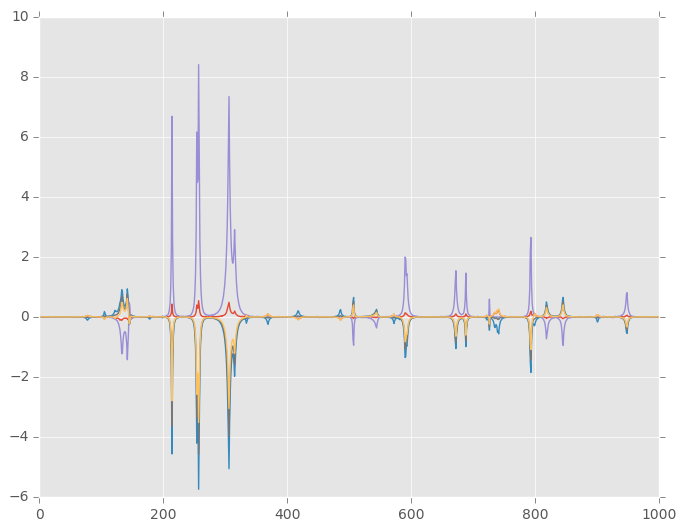

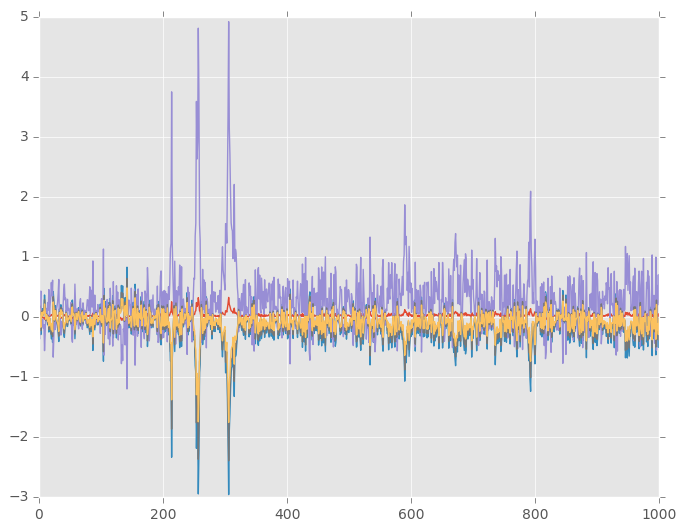

In [20]:
yhat = similar(y)

for t in 1:Nt
    yhat[:, t] = kron(η[:, 1, t]', Θ) * ξ[:, t]
end

plot(y')
figure()
plot(yhat');

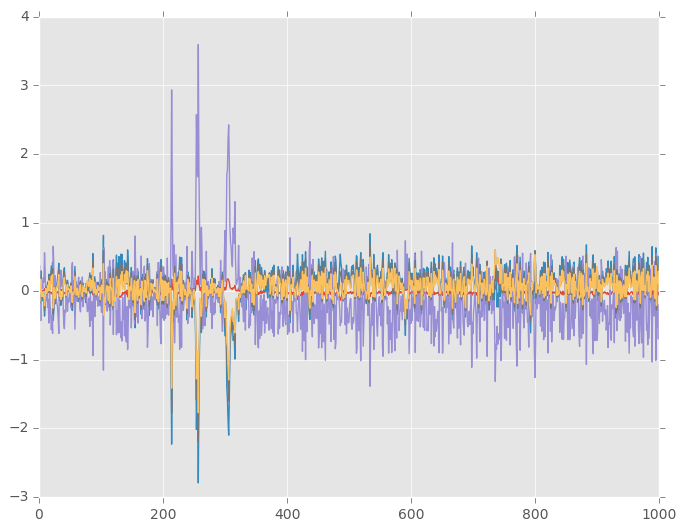

5x1 Array{Float64,2}:
 0.0013463
 0.106559 
 0.235229 
 0.0670795
 0.0411081

In [21]:
plot((y - yhat)')

SS = sum( (y - yhat).^2, 2) / Nt

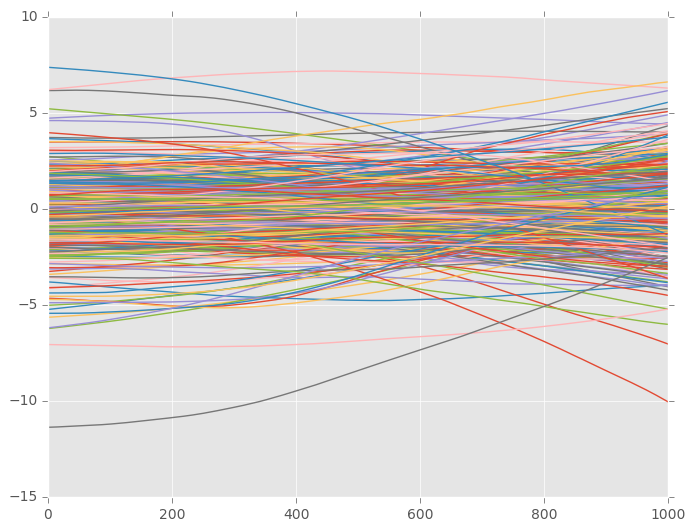

In [22]:
plot(squeeze(ψ_mat[1, :, :], 1));

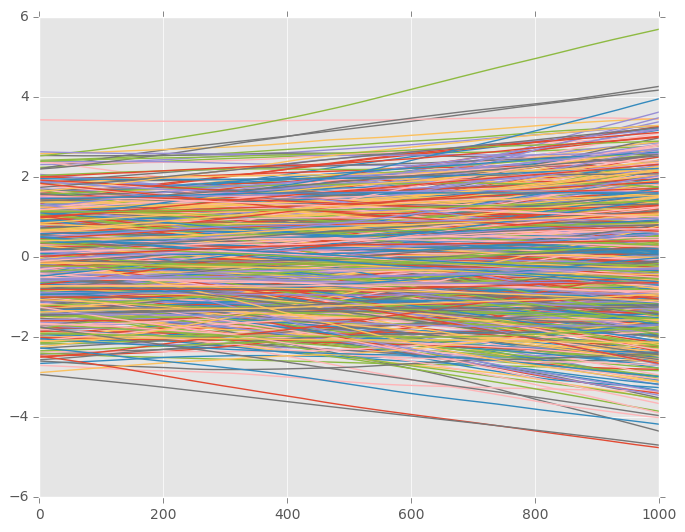

In [35]:
plot(squeeze(ψ_mat[2, :, :], 1));

In [36]:
σξ, σA, Σ0

([8.579273450920876,10.216211305631823,13.839519440054312,9.065152073273147],[11.163670455302897,10.149765838584948,15.563839951810467,12.96819128556245],
5x5 Array{Float64,2}:
 0.00488175  0.0       0.0       0.0      0.0     
 0.0         0.327025  0.0       0.0      0.0     
 0.0         0.0       0.975665  0.0      0.0     
 0.0         0.0       0.0       0.27242  0.0     
 0.0         0.0       0.0       0.0      0.152887)

In [37]:
Θ

5x2 Array{Float64,2}:
  0.00713458  -0.00725216
 -0.0658693    0.092625  
  0.107126    -0.0711399 
 -0.0529333    0.0600461 
 -0.0390014    0.0508891 

In [38]:
ξ

4x1001 Array{Float64,2}:
  3.10901    3.10834    3.10819   …  -1.96512   -1.98323   -2.00193 
 -0.591913  -0.592087  -0.592599     -1.07368   -1.07831   -1.08354 
  1.38483    1.3848     1.38505       8.95705    8.96385    8.97075 
  0.283471   0.283471   0.283471      0.283471   0.283471   0.283471

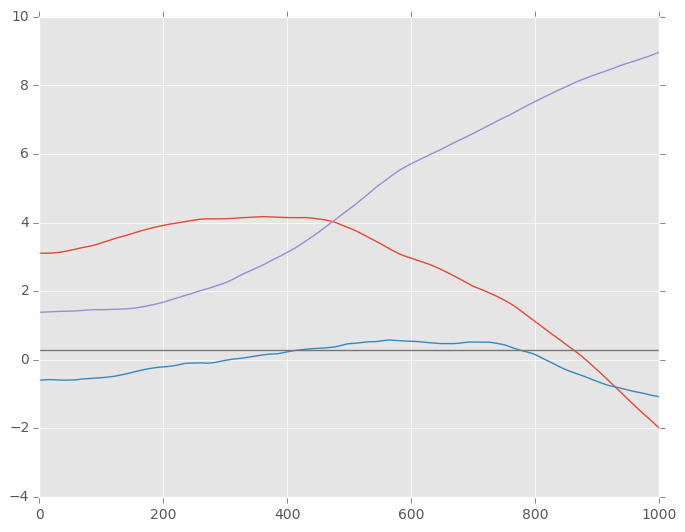

4-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x310fe3d90>
 PyObject <matplotlib.lines.Line2D object at 0x310ff30d0>
 PyObject <matplotlib.lines.Line2D object at 0x310ff33d0>
 PyObject <matplotlib.lines.Line2D object at 0x310ff36d0>

In [39]:
plot(ξ')

In [40]:
Ψ

2x1001 Array{Float64,2}:
 -0.188259  -0.18736  -0.18638  -0.185449  …  0.802299  0.80507  0.807736
  1.12986    1.12988   1.12988   1.12988      1.39365   1.39412  1.39464 

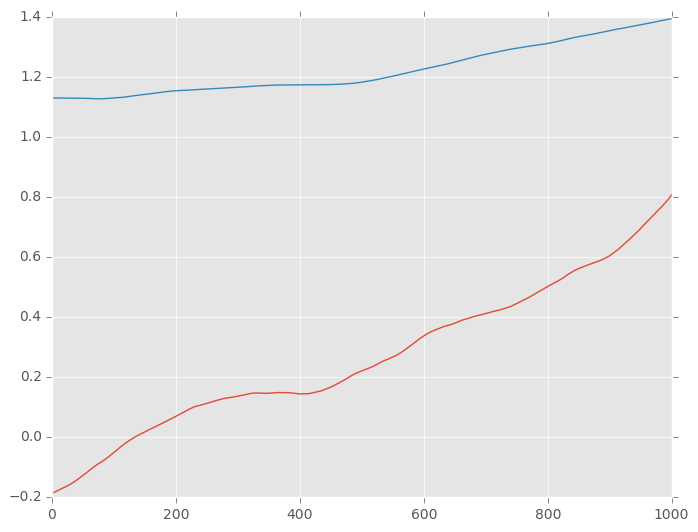

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3265d34d0>
 PyObject <matplotlib.lines.Line2D object at 0x3265d3650>

In [41]:
plot(Ψ')

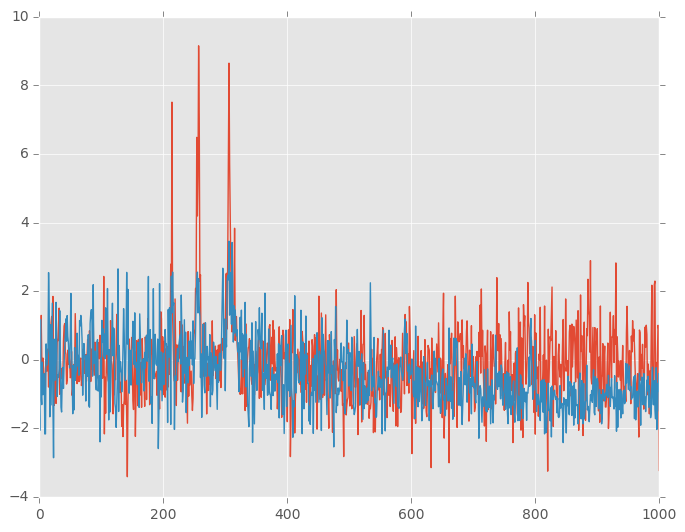

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x325da8090>
 PyObject <matplotlib.lines.Line2D object at 0x325da8310>

In [42]:
plot(squeeze(η, 2)' - Ψ')

In [43]:
τ

2-element Array{Float64,1}:
  7.47539
 15.508  

In [44]:
ϑ

2-element Array{Float64,1}:
 7.47539
 2.07454

In [45]:
ϕ

5x2 Array{Float64,2}:
 1.26222   2.15437 
 2.32814   2.1637  
 0.635995  1.7076  
 0.355741  2.57474 
 1.52592   0.858171

In [46]:
η

2x1x1001 Array{Float64,3}:
[:, :, 1] =
 -0.256625
 -0.149669

[:, :, 2] =
 -0.668499
 -0.930742

[:, :, 3] =
 -0.341588
  2.30301 

...

[:, :, 999] =
 1.80604 
 0.469252

[:, :, 1000] =
 1.69614 
 0.990608

[:, :, 1001] =
 -2.41979  
 -0.0927234

In [47]:
σψ, σB

([22.166891001619394,2.605903443129757],[1.9636762106334045,0.6330365079299506])